In [1]:
#https://www.dummies.com/programming/python/plotting-a-sound-file-in-ipython/
import matplotlib.pyplot as plt
#from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
from gurobipy import *
from IPython.display import Audio
import os
import glob
#import untangle

import xml.etree.ElementTree as et
import pandas as pd
import re
from sklearn.metrics import f1_score
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import soundfile

import panel as pn 

# Functions

In [2]:
# Function for transforming a signal with fourier
def fourier_trans(data, rate, begin_time, end_time): 
    # initialising variables
    tp_count = len(data)
    values = np.arange(int(tp_count/2))
    time_period = tp_count/rate
    frequencies = values/time_period
    
    #at what intervals time points are sampled
    sampling_interval = 1/rate;
    
    #time points
    time = np.arange(begin_time, end_time, sampling_interval);
    
    #Frequency domain representation
    fourier_transform = fft(data)/tp_count #normalized the amplitude
    fourier_transform = fourier_transform[range(int(len(data)/2))] #exclude sampling frequency   
    return frequencies, abs(fourier_transform)

# TODO: Funktion überarbeiten damit man es auch versteht!
def new_fft(data, rate):
    """ Return the Fast Fourier Transform sample frequencies and amplitudes.

    Args:
        data(numpy.ndarray):A list of data points of the given signal
        rate(int):The number of sample rate

    Returns:
        freq(numpy.ndarray):A list of sample frequencies.
        ampl(numpy.ndarray):A list of sample amplitudes.

    """
    N = len(data)

    # sample spacing
    T = 1.0 / rate
    x = np.linspace(0.0, N*T, N)

    yf = fft(data)
    freq = np.linspace(0.0, 1.0/(2.0*T), N//2)
    ampl = 2.0/N * np.abs(yf[0:N//2])
    return freq, ampl

# TODO: Warnung herausgeben wenn bei der Teilung der Samplerate eine Fliesskommazahl entsteht
def easy_downsampling(data, rate, sampl_fac):
    """ Lowers the amount of sampled datapoints.

    Args:
        data(numpy.ndarray):A list of data points of the given signal
        rate(int):The number of sample rate
        sampl_fac(int): A number n where it lowers the sample datapoints to 1/n

    Returns:
        ds_data(numpy.ndarray):A list of datapoints, where it is lowered by the sampl_fac.
        ds_rate(int):The number of lowered sample rate
    """
    ds_data = []
    for i in range(len(data)):
        if (i%sampl_fac == 0):
            ds_data.append(data[i])
    ds_rate = int(rate/sampl_fac)
    return ds_data, ds_rate

#ToDo: startwert von 0 nicht möglich, überarbeiten!!

def snip_wav(data, rate, start_sec, end_sec):
    """ Cuts down the datapoints.

    Args:
        data(numpy.ndarray):A list of data points of the given signal
        rate(int):The number of sample rate
        start_sec(float):The onset where the signal starts.
        end_sec(float):The offset where the signal ends.

    Returns:
        snip_data(numpy.ndarray):The a binarised vector.
        rate(int):The number of sample rate
        
    """
    start_point = int((rate * start_sec)-1)
    end_point = int((rate * end_sec)-1)
    #print('start_point:', start_point)
    #print('end_point:', end_point)
    snip_data = data[start_point:end_point]
    #print(snip_data)  
    return snip_data, rate

# Berechnung Vector target
#def calc_target_vec(pitch):
#    pitch_start = 40
#    #pitch_end = 76
#    pitch_end = pitch_start + 77 #TODO: muss angepasst werden
#    target_vec = []
#    
#    if pitch_start <= pitch <= pitch_end:
#        for pitch_act in range(pitch_start, pitch_end+1):
#            
#            if pitch_act == pitch:
#                target_vec.append(1)
#            else:
#                target_vec.append(0)
#    else:
#        print('Pitch muss innerhalb der Range({} - {})!'.format(pitch_start, pitch_end))
#    
#    return target_vec

def calc_target_vec(pitch):
    """ Returns a binarised vector, where 1 indicates the existence of the pitch, and 0 if not.

    Args:
        pitch (numpy.ndarray):The pitch which is to be binarised.

    Returns:
        target_vec(numpy.ndarray):The a binarised vector.

    """
    pitch_start = 40
    pitch_end = 76
    #pitch_end = pitch_start + 77 #TODO: muss angepasst werden
    combi_vec = []
    for element in pitch:
        pitch_vec = []
        if pitch_start <= element <= pitch_end:
            for pitch_act in range(pitch_start, pitch_end+1):
                if pitch_act == element:
                    pitch_vec.append(1)
                else:
                    pitch_vec.append(0)
            combi_vec.append(pitch_vec)
        else:
            print('Pitch {} muss innerhalb der Range({} - {})!'.format(pitch, pitch_start, pitch_end))
            return[0] * (pitch_end - pitch_start + 1) # for harmonics
    target_vec = [sum(x) for x in zip(*combi_vec)]
    return target_vec

def norm_vec(vector):
    """ Returns a normalised vector, where the sum of its square equals 1.

    Args:
        vector (numpy.ndarray):The vector which is to be normalised.

    Returns:
        norm_v(numpy.ndarray):The vector which is normalised.
        vector(numpy.ndarray):The vector which cannot be normalised.

    """
    norm_factor = np.linalg.norm(vector)
    if (norm_factor != 0):
        norm_v = vector/norm_factor
        return norm_v
    else:
        print('Der Vektor kann nicht normalisiert werden.')
        return vector

def metric(target_v, approx_v):
    """ Returns the sum of differences between two vectors.

    Args:
        target_v (numpy.ndarray):The vector which is to be approximated.
        approx_v (numpy.ndarray):The actual approximated vector calculated from Gurobi.


    Returns:
        diff_sum(numpy.float64):The sum of differences which is normalised.   

    """
    norm_v = norm_vec(approx_v)
    diff = target_v - norm_v
    diff_sum = np.sum(np.abs(diff))
    return diff_sum  

def vec_to_pitch(vec):
    """ Converts a binary vector to its pitches.

    Args:
        vec(ndarray): The binary vector to be converted.

    Returns:
        pitch(ndarray): A vector with pitches.

    """
    pitch_act = 40
    pitch = []
   
    for elem in vec:
        if elem == 1:
            pitch.append(pitch_act)
        pitch_act += 1
    return pitch

# Plot Function

In [44]:
# Frequency domain representation
def plot_freq_domain(freq, fourier, name):
    """ Shows a lineplot of the given signal.

    Args:
        freq (numpy.ndarray):A list with frequencies on the x axis.
        fourier (numpy.ndarray):A list with amplitudes on the y axis.
        name(str): A string which is displayed as the plot title.

    """
    plt.figure(figsize=(20,5))
    plt.plot(freq, fourier)
    plt.xlabel('Frequency in Hz')
    plt.ylabel('Amplitude')
    plt.xlim(0, 1400)
    plt.title(name)
    plt.show()

def plot_hist(all_pitches, width, height):
    """ Shows a distribution of the pitches in all files used.

    Args:
        all_pitches (list): A list which contains all pitches which are used.
               width (int): Width size of the plot.
              height (int): height size of the plot.
                                  
    Returns:
        A histogramm of the pitch distribution of all files.
    """
    
    # plot figure        
    fig_pitch_dist, ax_pitch_dist = plt.subplots(figsize=(10,4)) 
    bins = np.arange(min(all_pitches), max(all_pitches)+1)
    plt.xlim([min(all_pitches)-2, max(all_pitches)+2])


    min_pitch = min(all_pitches)   
    max_pitch = max(all_pitches)

    ref_min = min(df_ref_unique.pitch)
    ref_max = max(df_ref_unique.pitch)

    plt.hist(all_pitches, bins = bins, range=[min_pitch,max_pitch], alpha=0.5, width=0.8)
    plt.axvline(linewidth=2, color='#fc8803', x=ref_min, label='lowest pitch in reference pitches')
    plt.axvline(linewidth=2, color='r', x=ref_max, label='highest pitch in reference pitches')
    plt.title('pitch distribution')
    plt.xlabel('pitch')
    plt.ylabel('count')
    plt.legend(loc = 'upper left')
    plt.xticks(np.arange(min_pitch, max_pitch, 5))
    plt.close(fig_pitch_dist)
    return fig_pitch_dist

def plot_bar(note, width, height):
    """ Shows a distribution of the pitches in all files used.

    Args:
       note(int): A note which is to be analysed.
     width (int): Width size of the plot.
    height (int): height size of the plot.
                         
    Returns:
        A histogramm of the pitch distribution of all files.
    """

    pitch_list = np.arange(40, 77, 1)
    
    #test_tone = 152
    test_tone = note
    
    #create plot
    fig_thresh, ax = plt.subplots(figsize = (width, height))
    index = len(pitch_list)-1

    bar_width = 0.3
    opacity = 0.9

    target_rects = plt.bar(pitch_list, df_test.target_vec[test_tone], 
                           bar_width, alpha = opacity, label='target_vec', color='#3266a8')

    thresh_rects = plt.bar(pitch_list + 2*bar_width, df_test.thresholded_vec[test_tone], 
                           bar_width, alpha = opacity, label='thresh_vec', color='#00b82b')

    pred_rects = plt.bar(pitch_list + bar_width, df_test.pred_vec[test_tone], 
                         bar_width, alpha = opacity, label='pred_vec',color='orange')


    plt.axhline(linewidth=1, color='r', y=0.26, label='threshold')

    plt.xticks(pitch_list + bar_width, pitch_list)
    plt.xlim(pitch_list[0]-0.5, pitch_list[index]+1)
    ax.set_title('pitch detection')
    ax.set_ylabel('intensity')
    plt.tight_layout()
    plt.legend()
    plt.close(fig_thresh)
    return fig_thresh
    
def plot_box(mono_score, poly_score, width, height):
    """ Shows a distribution of the pitch score.

    Args:
        mono_score (pandas.core.series.Series): A list with frequencies on the x axis.
        poly_score (pandas.core.series.Series): A list with amplitudes on the y axis.
                                   width (int): Width size of the plot.
                                  height (int): height size of the plot.
                                  
    Returns:
        A distribution of the pitch scores as a boxplot.
    """
    pitch_score_data = [mono_score, poly_score]
    fig_box, ax_box = plt.subplots(figsize = (width, height))
    # Set the axes ranges and axes labels
    ax_box.set_xticklabels(['Monophone', 'Polyphone'])
    ax_box.set_ylabel('Pitch score')
    top = 10
    bottom = -1
    ax_box.set_ylim(bottom, top)

    ax_box.set_title('Distribution of pitch scores')
    ax_box.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax_box.boxplot(pitch_score_data)
    ax_box.text(0.95, -0.6, round(mono_score.median(), 2))
    ax_box.text(1.95, -0.6, round(poly_score.median(), 2))
    plt.close(fig_box)
    return fig_box

def plot_scatter(x_axis, y_axis, width, height):
    """ Shows a scatterplot of the pitch detection.

    Args:
        xAxis (list): A list with the range of all pitches.
        yAxis (list): A list with the range of all pitches.
         width (int): Width size of the plot.
        height (int): height size of the plot. 
        
    Returns:
        A scatterplot of the detected pitches.
    """
    #pitch_pred = [0, 41, 43, 51, 67, 44, 67]
    #pitch = [40, 41, 43, 51, 67, 44, 62 ]

    fig_scat, ax_scat = plt.subplots(figsize = (width, height))
    ax_scat.scatter(x_axis, y_axis, color='#00b82b')
    ax_scat.set_xlabel('pitch pred')
    ax_scat.set_ylabel('pitch')
    ax_scat.set_title('scatter plot')
    plt.xticks(np.arange(40, 80, 5))
    plt.yticks(np.arange(40, 95, 5))
    plt.grid(which='major')
 
    plt.close(fig_scat)
    return fig_scat

## Dataframe 

- fft normieren 
- alle werte von fft quadrieren + summe bilden -> darf nicht mehr als 1 geben! 

In [4]:
def read_xml_to_df(path, df_cols, offset_sec, duration_sec, sampl_fac):
    """ Converts an xml file to a dataframe.

    Args:
        path(str): The path where the xml is located
        df_cols(list): A list of strings which the dataframe should contain of. 
        offset_sec(float): The onset where the signal starts. 
        duration_sec(float): The duration of the signal
        sampl_fac(int): A number n where it lowers the sample datapoints to 1/n

    Returns:
        df(data frame): The converted xml file as a dataframe.

    """
    dataset = re.search(r'dataset.*\b', path).group(0)
    path_xml = path + "annotation"
    path_wav = path + "audio"  
    df = pd.DataFrame(columns=df_cols)
    
    for xml_file in sorted(glob.glob(os.path.join(path_xml, '*.xml'))):
        tree = et.parse(xml_file)
        root = tree.getroot()
        all_events = []
       
        for globalParam in root.findall('globalParameter'):
            audio_name = globalParam.find('audioFileName').text
            audio_name = audio_name.replace("\\", "")
            
            # Read wav-file
            wav_file = path_wav + '/' + audio_name
            data, rate = soundfile.read(wav_file)

        for transcription in root.findall('transcription'):

            for event in transcription.findall('event'):
                event_data = []
                event_data.append(dataset)
                event_data.append(audio_name)

                for elem in df_cols[len(event_data):]:
                    if event is not None:
                        if event.find(elem) is not None:
                            event_data.append(event.find(elem).text)
                            
                        elif elem == df_cols[3]:
                            onset_sec = event.find('onsetSec').text
                            event_data.append(onset_sec)
                            start_sec = round(offset_sec + float(onset_sec), 3)
                            end_sec = round(start_sec + duration_sec, 3)

                            # Snip and downsampling audio-file
                            data_snip, rate_snip = snip_wav(data, rate, start_sec, end_sec)
                            data_down, rate_down = easy_downsampling(data_snip, rate_snip, sampl_fac)

                            # Calc FFT
                            #freq, fourier = new_fft(data_down, rate_down)
                            freq, fourier = new_fft(data_snip, rate_snip)
                                                       
                        elif elem == 'amplitude':
                            event_data.append(fourier[:50])
                            #event_data.append(fourier[:50]*fourier[:50])


                        elif elem == 'frequency':
                            event_data.append(freq[:50])
                        else:
                            event_data.append(None)
                    else:
                        event_data.append(None)

                all_events.append({df_cols[i]: event_data[i] for i, _ in enumerate(df_cols)})
                
        combi_events = mono_poly_detection(all_events)
        df = df.append(pd.DataFrame(combi_events, columns=df_cols), ignore_index=True)
        
    return df

In [5]:
def mono_poly_detection(events):
    """ Detects whether a pitch is played alone or as a chord.

    Args:
        events(numpy.ndarray): A list where all events of a file 


    Returns:
        combi_events(numpy.ndarray):A list where all pitches played within 70ms is stored.

    """
    poly_time = 0.070
    
    dataset = events[0]['dataset']
    audioFileName = events[0]['audio_file_name']
    amp = events[0]['amplitude']
    freq = events[0]['frequency']
    
    onsets = []
    pitches = []
    combi_events = []

    
    for event in events:
        onsets.append(float(event['onset_sec']))
        pitches.append(int(event['pitch']))
        
    pitch_array = [pitches[0]]
    new_onset = onsets[0]
    

    for i in range(len(events)-1):
        if (onsets[i + 1]- onsets[i]) <= poly_time:
            pitch_array.append(pitches[i+1])
            new_onset = onsets[i+1]
            amp = events[i+1]['amplitude']
            freq = events[i+1]['frequency']
            
        else:
            combi_events.append({'dataset': dataset,
                               'audio_file_name': audioFileName,
                               'pitch': pitch_array,
                               'onset_sec': new_onset,
                               'amplitude': amp,
                               'frequency': freq,
                              })
            
            pitch_array = [pitches[i+1]]
            new_onset = onsets[i+1]
            amp = events[i+1]['amplitude']
            freq = events[i+1]['frequency']
            
    combi_events.append({'dataset': dataset,
                   'audio_file_name': audioFileName,
                   'pitch': pitch_array,
                   'onset_sec': new_onset,
                   'amplitude': amp,
                   'frequency': freq,
                  })

    return combi_events

# Init Dataframe

In [6]:
# Set audio snippets and sample compression
offset_sec = 0.01
duration_sec = 0.05
sampl_fac = 1

# Create empty Dataframe
df_cols = ['dataset', 'audio_file_name', 'pitch', 'onset_sec', 'amplitude', 'frequency']
df_ref = pd.DataFrame(columns=df_cols)
df_test = pd.DataFrame(columns=df_cols)

# Create Dataframe with reference tones

In [7]:
%%time
# paths
path_main = "IDMT-SMT-GUITAR_V2/"
path_main_ref = path_main + "dataset1/Fender Strat Clean Neck SC/"
#path_main_ref = path_main + "dataset1/Fender Strat Clean Neck SC Chords/"

df_ref = read_xml_to_df(path_main_ref, df_cols, offset_sec, duration_sec, sampl_fac)
df_ref.head(10)
#df_ref.pitch

CPU times: user 466 ms, sys: 87.8 ms, total: 554 ms
Wall time: 816 ms


,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
5,dataset1/Fender Strat Clean Neck SC,G53-45105-1111-00006.wav,[45],0.2,"[0.009527075804280047, 0.012250241045892342, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
6,dataset1/Fender Strat Clean Neck SC,G53-45200-1111-00014.wav,[45],0.2,"[0.001084571198270975, 0.002188941124022176, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
7,dataset1/Fender Strat Clean Neck SC,G53-46106-1111-00007.wav,[46],0.2,"[0.004128384752338435, 0.002491926601108584, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
8,dataset1/Fender Strat Clean Neck SC,G53-46201-1111-00015.wav,[46],0.2,"[0.00517525532348356, 0.0037794923178455474, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
9,dataset1/Fender Strat Clean Neck SC,G53-47107-1111-00008.wav,[47],0.2,"[0.002118874893707483, 0.0004992268356448354, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."


# Create Dataframe with testdatas

In [8]:
%%time
# paths testdata

path_testdata = [
    path_main + 'dataset1/Fender Strat Clean Neck SC/',
    path_main + 'dataset1/Fender Strat Clean Neck SC Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge+Neck SC/',
    path_main + 'dataset1/Ibanez Power Strat Clean Neck HU/',
    path_main + 'dataset2/']

for path in path_testdata:
    df_act = read_xml_to_df(path, df_cols, offset_sec, duration_sec, sampl_fac)
    df_test = df_test.append(df_act, ignore_index=True)
df_test

CPU times: user 11.4 s, sys: 1.59 s, total: 13 s
Wall time: 21 s


,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2000,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2000,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2000,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2000,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2000,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
...,...,...,...,...,...,...
4448,dataset2,LP_V_vibrato_slow-fast.wav,[60],43.0498,"[0.002487341671033241, 0.004921049887680139, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4449,dataset2,LP_V_vibrato_slow-fast.wav,[64],49.6065,"[0.0050438371645350035, 0.0022661671921127076,...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4450,dataset2,LP_V_vibrato_slow-fast.wav,[64],55.5450,"[0.0024214063371930804, 0.002211863439550683, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4451,dataset2,LP_V_vibrato_slow-fast.wav,[69],62.3891,"[0.0031924125558935325, 0.002750274986731963, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."


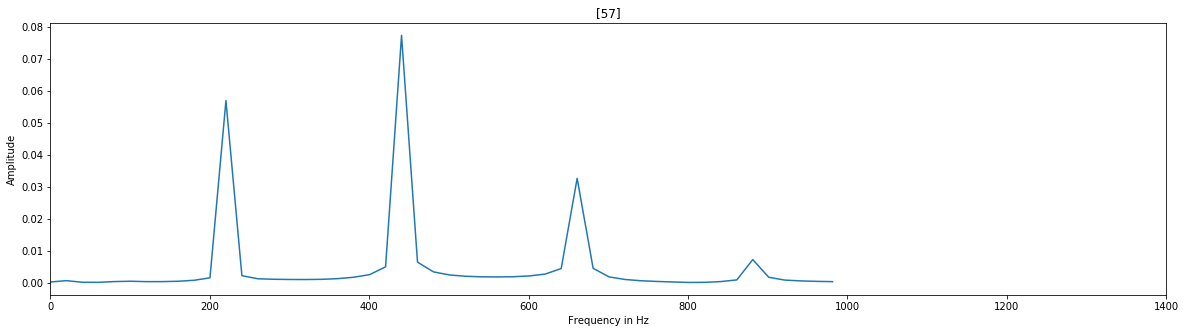

50

In [9]:
pitch = 36
plot_freq_domain(df_test.frequency[pitch], df_test.amplitude[pitch], df_test.pitch[pitch])
len(df_test.amplitude[pitch])

In [10]:
# drop duplicate in df_ref
df_ref_unique = pd.DataFrame(columns=df_cols)
 
for index, row in df_ref.iterrows():
    if not df_ref_unique.pitch.str.contains(row.pitch[0], regex=False).any():
        df_ref_unique = df_ref_unique.append(row, ignore_index=True)
df_ref_unique.head()

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."


## Histogram of Pitches Distribution

pitch min: 40
pitch max: 92


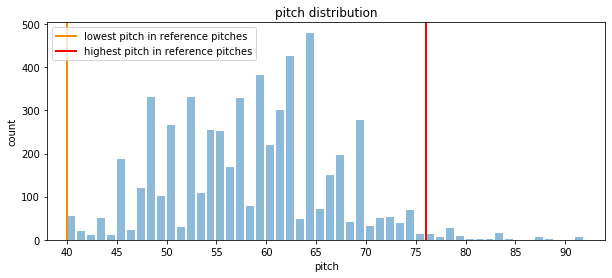

In [11]:
all_pitches_temp = df_test.pitch.tolist()
 
# flatten List
all_pitches = []
for sublist in all_pitches_temp:
    for item in sublist:
        all_pitches.append(item)

plot_hist(all_pitches, 10, 4)

# Gurobi

In [12]:
# Build Model
m = Model('AMt')

lambs = []
for lamb in range(len(df_ref_unique)):
    lambs.append(m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_' + str(lamb)))
m.update()

Academic license - for non-commercial use only


In [14]:
%%time
pred_vec = []

len_lambs = len(lambs)
gamma = 2

amplitudes = df_test.amplitude.tolist()

for amplitude in amplitudes:

    mischsignal = amplitude
    len_mischsignal = len(mischsignal)

    cost_function = 0
    approxi_sgn = 0  
    penalty = 0
    #print(type(cost_function))
    #cost_function = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'CostFunction')
    #approxi_sgn = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'approxi_sgn')

    for lamb in range(len_lambs):
        la = lambs[lamb]
        note = df_ref_unique.amplitude[lamb]
        penalty += la * la
        

        for sgn in range(len_mischsignal):
            approxi_sgn = la * note[sgn]
            mi = mischsignal[sgn]
            
            deviation = mi - approxi_sgn
            
            cost_function += deviation * deviation
    
    #Constraints
    m.addConstrs((lambs[i] <= 1 for i in range(6)), name='c')

    #Params
    m.params.outputflag = 0 # Infotext ausblenden
    #m.params.presolve = 0
    
    m.setObjective(cost_function + gamma * penalty, GRB.MINIMIZE)
    m.optimize()


    approx_v = []

    for v in m.getVars():
        #print('%s: %g' % (v.varName, v.x))
        approx_v.append(v.x)

    pred_vec.append(approx_v)

CPU times: user 7min 8s, sys: 9.65 s, total: 7min 18s
Wall time: 8min


In [15]:
df_test['pred_vec'] = pred_vec

# Calculate Pitch Score

In [16]:
# Calc all target vectors
target_pitches = df_test.pitch.array
target_vec = []

for pitch in target_pitches:
    target_vec.append(calc_target_vec(pitch))

df_test['target_vec'] = target_vec
df_test.head()

Pitch [77] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [79] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [77] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [79] muss innerhalb der Range(40 - 76)!
Pitch [80] muss innerhalb der Range(40 - 76)!
Pitch [81] muss innerhalb der Range(40 - 76)!
Pitch [82] muss innerhalb der Range(40 - 76)!
Pitch [83] muss innerhalb der Range(40 - 76)!
Pitch [84] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [83] muss innerhalb der Range(40 - 76)!
Pitch [87] muss innerhalb der Range(40 - 76)!
Pitch [92] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [83] muss innerhalb der Range(40 - 76)!
Pitch [87] muss innerhalb der Rang

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,pred_vec,target_vec
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005064749776212221, 0.0029681966302376656, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.0029690984019437915, 0.005366930551861721, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.002424731049151919, 0.0035161441734940517, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.001566262576412335, 0.0025463187124069877, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.0026640769060912017, 0.00284525729646096, 0...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [17]:
pitch_score = []
#vec_target = df_test.pitch.array

for vec in range(len(pred_vec)):
    pitch_score.append(metric(target_vec[vec], pred_vec[vec]))
    
df_test['pitch_score'] = pitch_score
df_test.head()

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,pred_vec,target_vec,pitch_score
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005064749776212221, 0.0029681966302376656, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.403375
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.0029690984019437915, 0.005366930551861721, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.599587
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.002424731049151919, 0.0035161441734940517, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.872493
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.001566262576412335, 0.0025463187124069877, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.943700
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.0026640769060912017, 0.00284525729646096, 0...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.605688


# Calculate F1 Score

In [18]:
# thresholding vec_pred
%time
thresholded_vec = []
norm_pred_vec = []
pitch_pred = []
#v_pred = df_test.pred_vec

for j in range(len(pred_vec)):
    thresh_vec = []
    vec = norm_vec(pred_vec[j])
    
    for i in range(len(vec)):
        if vec[i]> 0.22:
            thresh_vec.append(1)
        else:
            thresh_vec.append(0)
            
    thresholded_vec.append(thresh_vec)
    norm_pred_vec.append(vec)
    pitch_pred.append(vec_to_pitch(thresh_vec))
    
df_test['thresholded_vec'] = thresholded_vec
df_test['norm_pred_vec'] = norm_pred_vec
df_test['pitch_pred'] = pitch_pred

df_test.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,pred_vec,target_vec,pitch_score,thresholded_vec,norm_pred_vec,pitch_pred
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.005064749776212221, 0.0029681966302376656, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.403375,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, ...","[0.29983378107372577, 0.17571758881245864, 0.1...","[40, 50, 51, 52]"
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0005969542765022676, 0.0017092017487395916,...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.0029690984019437915, 0.005366930551861721, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.599587,"[0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, ...","[0.19246682316067332, 0.347902269848832, 0.228...","[41, 42, 45, 48, 50, 52, 53, 54]"
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.0034228128100198415, 0.00428068727065624, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.002424731049151919, 0.0035161441734940517, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.872493,"[0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0.1707729848546472, 0.24764084078391918, 0.25...","[41, 42, 44, 45, 52, 53, 54]"
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0007040495234552155, 0.001659174406915279, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.001566262576412335, 0.0025463187124069877, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.943700,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.10329018821975541, 0.16792186893365635, 0.1...","[43, 44, 45, 55, 56]"
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0.0026640769060912017, 0.00284525729646096, 0...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.605688,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.15889626638078322, 0.16970259389533202, 0.1...","[43, 44, 45, 52, 55, 56]"


In [19]:
#x = df_test.Vec_Pred_Norm[0]
#np.amax(x)
max_val = []
for i in df_test.norm_pred_vec:
    max_val.append(np.amax(i))
    
threshold = min(max_val)
print('optimal threshold for binarizing vec pred is: ', threshold)

optimal threshold for binarizing vec pred is:  0.2283548029243334


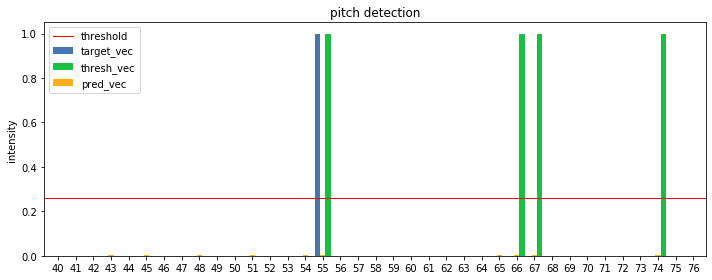

In [20]:
plot_bar(152, 10, 4)

In [21]:
combi_target_vec = []
for i in df_test.target_vec:
    for elem in i:
        combi_target_vec.append(elem)
#print(target_vecs)

combi_pred_vec = []
for i in df_test.thresholded_vec:
    for elem in i:
        combi_pred_vec.append(elem)

# Save/Load Dataframe

In [22]:
df_test.to_pickle('file_name')

In [23]:
#df_test = pd.read_pickle('file_name')

# Scores

In [24]:
df_test['mono_poly'] = df_test.pitch.apply(lambda x: len(x))
pitch_score_mono = df_test.loc[df_test.mono_poly == 1].pitch_score.mean()
pitch_score_poly = df_test.loc[df_test.mono_poly > 1].pitch_score.mean()
mono_count = len(df_test.loc[df_test.mono_poly==1])
poly_count = len(df_test.loc[df_test.mono_poly>1])
total_count = mono_count + poly_count
anteil_mono = mono_count/total_count
anteil_poly = poly_count/total_count
total_pitch_score = pitch_score_mono*anteil_mono  + pitch_score_poly*anteil_poly

print('Possible number of Pichtes', df_test.mono_poly.unique())

print('Anzahl Monos: ', mono_count)
print('Anzahl Polys: ', poly_count)
print('Anzahl Files: ', total_count)

print('Pitch Score Mono: ', round(pitch_score_mono, 2))
print('Pitch Score Poly: ', round(pitch_score_poly, 2))

print('Total Pitch Score: ', round(total_pitch_score, 3))


Possible number of Pichtes [1 6 5 3 2 4]
Anzahl Monos:  3942
Anzahl Polys:  511
Anzahl Files:  4453
Pitch Score Mono:  5.77
Pitch Score Poly:  7.5
Total Pitch Score:  5.969


In [25]:
print(classification_report(combi_target_vec, combi_pred_vec))

              precision    recall  f1-score   support

           0       0.99      0.89      0.93    159168
           1       0.18      0.72      0.29      5593

    accuracy                           0.88    164761
   macro avg       0.59      0.80      0.61    164761
weighted avg       0.96      0.88      0.91    164761



# Boxplots

In [26]:
mono_score = df_test.loc[df_test.mono_poly == 1].pitch_score
poly_score = df_test.loc[df_test.mono_poly > 1].pitch_score

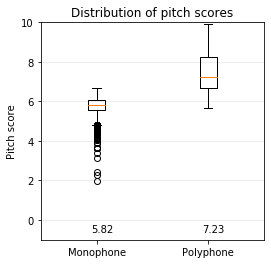

In [27]:
plot_box(mono_score, poly_score, 4, 4)

# Scatterplot

In [28]:
# New 24.12.2019
df_mono = df_test.loc[df_test.mono_poly == 1]
mono_pitches = df_mono.pitch
mono_pitches

0       [40]
1       [41]
2       [42]
3       [43]
4       [44]
        ... 
4448    [60]
4449    [64]
4450    [64]
4451    [69]
4452    [69]
Name: pitch, Length: 3942, dtype: object

In [29]:
print('Pitch should be:', df_mono.pitch[1])
vec = df_mono.thresholded_vec[1]
print('Vec_pred:')
print(vec)
print('Pitch pred:', vec_to_pitch(vec))

Pitch should be: [41]
Vec_pred:
[0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Pitch pred: [41, 42, 45, 48, 50, 52, 53, 54]


In [30]:
mono_pitches = []
mono_pitches_pred = []
df_mono = df_test.loc[df_test.mono_poly == 1]
 
for index, row in df_mono.iterrows():
    len_pitch_pred = len(row.pitch_pred) 
    #print('Pitch: {}, Länge: {}'.format(row.pitch, len_pitch_pred))
   
    for item in row.pitch:
        for i in range(len_pitch_pred):
            mono_pitches.append(item)
            i += 1
    for item in row.pitch_pred:
        mono_pitches_pred.append(item)

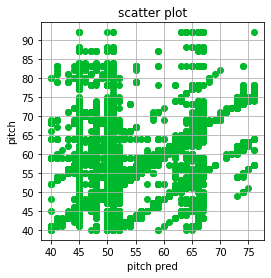

In [31]:
# test values
pitch_pred = [0, 41, 43, 51, 67, 44, 67]
pitch = [40, 41, 43, 51, 67, 44, 62 ]

plot_scatter(mono_pitches_pred, mono_pitches, 4, 4)

In [32]:
pn.extension()

GridSpec(height=800, sizing_mode='fixed', width=800)
    [0] Matplotlib(Figure, height=200, width=200)
    [1] Matplotlib(Figure, height=200, width=600)
    [2] Str(Empty, height=200, width=600)
    [3] Matplotlib(Figure, height=200, width=600)
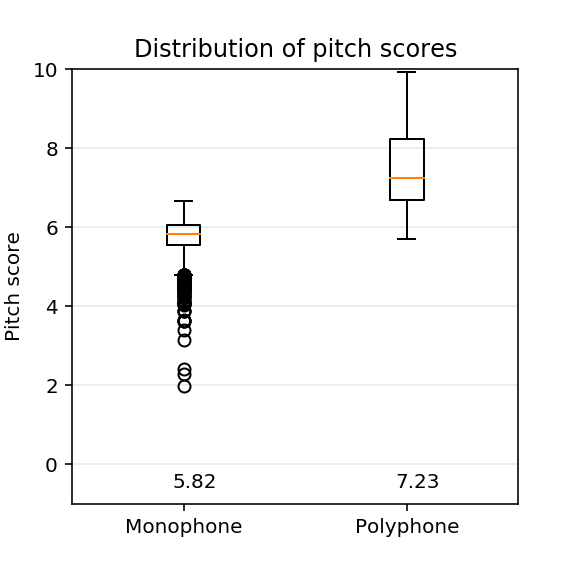
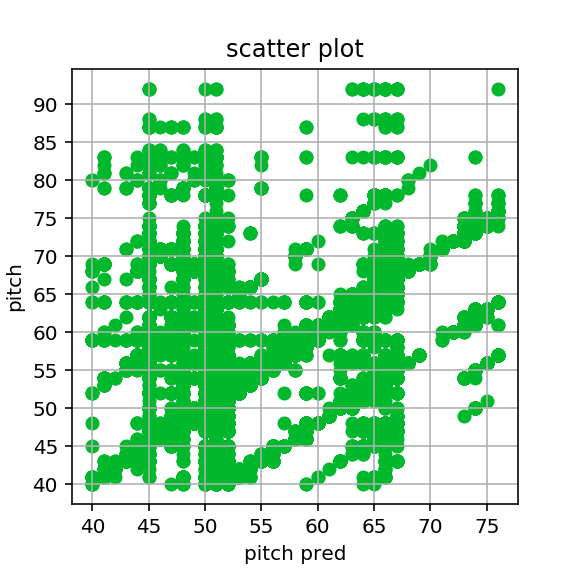
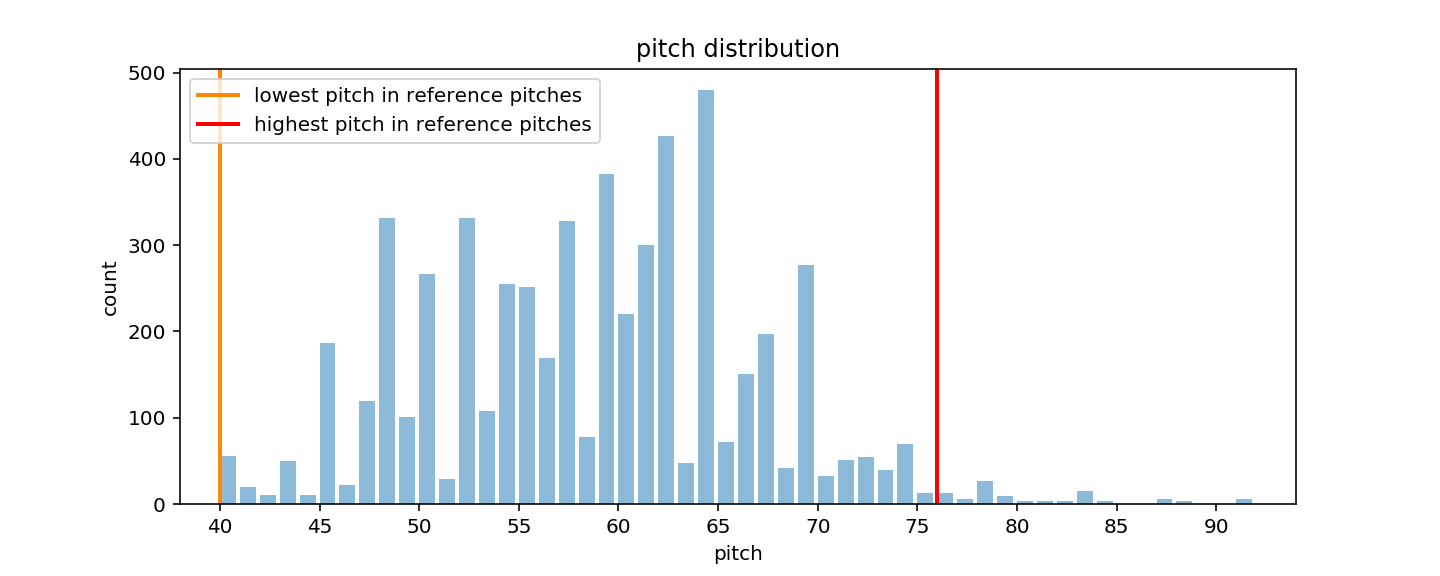

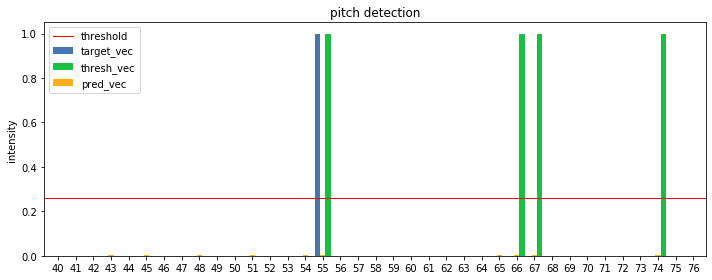

In [37]:
gspec = pn.GridSpec(width=800, height=800)

gspec[0,   0  ] = plot_scatter(mono_pitches_pred, mono_pitches, 4, 4)
gspec[2,   0:3] = plot_box(mono_score, poly_score, 4, 4)
gspec[3,   0:3] = plot_bar(152, 10, 4)
gspec[0,   1:4] = plot_hist(all_pitches, 10, 4)

gspec

In [54]:
title = '<div style="text-align: center; vertical-align: center; font-size: 40px; style: bold; margin: 0; position: absolute; top: 50%; left:45%; -ms-transform: translateY(-50%); transform: translateY(-50%);"> Dashboard </div>'

In [77]:
dashboard = pn.GridSpec(sizing_mode='scale_width', max_height=800)
dashboard[0, :] = title
dashboard[1, :2] = plot_hist(all_pitches, 10, 4)
dashboard[3 ,0:2] = plot_bar(152, 10, 4)
dashboard[1, 2] = plot_box(mono_score, poly_score, 4, 4)
dashboard[2, 3:4] = plot_scatter(mono_pitches_pred, mono_pitches, 6, 6)
dashboard[2, 0:2] = plot_bar(152, 10, 4)
dashboard.show()